In [7]:
from __future__ import print_function
import os

import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, Adadelta, Adamax, Nadam, Adagrad, SGD, RMSprop
import warnings
warnings.filterwarnings('ignore')

# Data Set

### 40 patients' MR images containing 4 phases and one masked image.

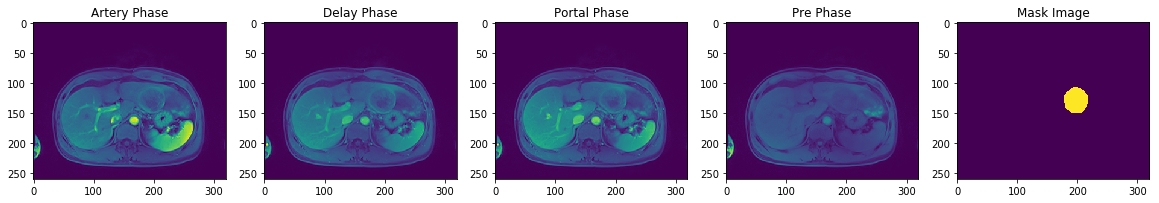

In [22]:
location = "MRI/FZMC001"
artery=nib.load(location+"/artery.nii")
artery=artery.get_data().T

delay=nib.load(location+"/delay.nii")
delay=delay.get_data().T

portal=nib.load(location+"/portal.nii")
portal=portal.get_data().T

pre=nib.load(location+"/pre.nii")
pre=pre.get_data().T

label=nib.load(location+"/label.nii")
label=label.get_data().T

plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.imshow(artery[40])
plt.title("Artery Phase")

plt.subplot(1,5,2)
plt.imshow(delay[40])
plt.title("Delay Phase")

plt.subplot(1,5,3)
plt.imshow(portal[40])
plt.title("Portal Phase")

plt.subplot(1,5,4)
plt.imshow(pre[40])
plt.title("Pre Phase")

plt.subplot(1,5,5)
plt.imshow(label[40])
plt.title("Mask Image")
plt.show()

# Preprocessing Data

In [3]:
class Dataset:
    def __init__(self, location):
        self.location = location
        self.artery_file = "/artery.nii" 
        self.delay_file = "/delay.nii"  
        self.portal_file = "/portal.nii"
        self.pre_file = "/pre.nii"
        self.label_file = "/label.nii"
        self.data_width = 320
        self.data_height = 260
    
    def load_data(self, phase_file):
        folders = os.listdir(self.location)
        
        x_data = y_data = np.array([]).reshape(0,self.data_height,self.data_width)
        
        for name in folders: 
            phase_path = str(location+name+phase_file)
            label_path = str(location+name+self.label_file)

            if os.path.exists(phase_path) and os.path.exists(label_path):
                # load images and transport the shape
                phase_nii=nib.load(phase_path)
                phase_img=phase_nii.get_data().T
                label_nii=nib.load(label_path)
                label_img=label_nii.get_data().T
                # concat a whole images
                if phase_img.shape[0] == label_img.shape[0]:
                    for i in range(len(label_img)):
                        if np.max(label_img[i])==1:
                            x_data = np.concatenate((x_data, phase_img[i:i+1]),axis=0)  
                            y_data = np.concatenate((y_data, label_img[i:i+1]),axis=0)      
         
        return x_data, y_data
    
    def normalized(self, data):
        data = np.array([file/np.max(file) for file in data])
        return data
        
    def preprocess(self, data, size):
        height, width = data.shape[1:]
        dif_h=0
        dif_w=0

        if height>width:
            dif_h = int((height-width)/2)
        elif height<width:
            dif_w = int((width-height)/2)

        resized_data = data[:,dif_h:height-dif_h,dif_w:width-dif_w]
        resized_data = np.array([cv2.resize(t,(size,size)) for t in data])
        return resized_data      
        
    def get_train_test_data(self, phase_file, size=256):
        x_data, y_data = self.load_data(phase_file)
        #x_data = self.preprocess(x_data,size)
        #y_data = self.preprocess(y_data,size)
        
        x_data = self.normalized(x_data)        
        
        train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=100)
        print("Using %s images for training and %s images for testing" % (len(train_x), len(test_x)))
        
        sample_width, sample_height = x_data.shape[1:]
        
        train_x = np.array([t.reshape(sample_height,sample_width,1) for t in train_x])
        test_x  = np.array([t.reshape(sample_height,sample_width,1) for t in test_x])
        train_y = np.array([t.reshape(sample_height,sample_width,1) for t in train_y])
        test_y  = np.array([t.reshape(sample_height,sample_width,1) for t in test_y])
        
        return train_x, test_x, train_y, test_y

In [8]:
location = "MRI/"
ds = Dataset(location)
train_x, test_x, train_y, test_y = ds.get_train_test_data(ds.artery_file)

Using 656 images for training and 164 images for testing


In [19]:
x_size = train_x.shape[1]
y_size = train_x.shape[2]

print("Shape: ", train_x.shape, test_x.shape, train_y.shape, test_y.shape)
print("Max value: ", np.max(train_x),np.max(test_x),np.max(train_y),np.max(test_y))
print("x_size:",x_size,"y_size:",y_size)

Shape:  (656, 320, 260, 1) (164, 320, 260, 1) (656, 320, 260, 1) (164, 320, 260, 1)
Max value:  1.0 1.0 1.0 1.0
x_size: 320 y_size: 260


# Loss Function

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Methods

### FCN Model

In [ ]:
def fcn(x,y):
    inputs = Input((x,y, 1))
    
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = Activation("relu")(conv1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), padding='same')(pool2)
    conv3 = Activation("relu")(conv3)
    conv4 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv4 = Activation("relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    split5 = Conv2D(1, (1, 1), padding='same')(pool4)
    split5 = Activation("relu")(split5)
    
    conv5 = Conv2D(128, (3, 3), padding='same')(pool4)
    conv5 = Activation("relu")(conv5)
    conv6 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv6 = Activation("relu")(conv6)
    pool6 = MaxPooling2D((2, 2), strides=(2, 2))(conv6)
    
    split7 = Conv2D(1, (1, 1), padding='same')(pool6)
    split7 = Activation("relu")(split7)
    split7 = Deconvolution2D(1, 4, 4,
            output_shape=(None, 1, 30, 30),
            subsample=(2, 2),
            border_mode='valid')(split7)
    split7 = Cropping2D(cropping=((1, 1), (0, 1)))(split7)
    
    conv7 = Conv2D(128, (3, 3), padding='same')(pool6)
    conv7 = Activation("relu")(conv7)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv8 = Activation("relu")(conv8)
    pool8 = MaxPooling2D((2, 2), strides=(2, 2))(conv8)
    
    split9 = Conv2D(1, (1, 1), padding='same')(pool8)
    split9 = Activation("relu")(split9)
    split9 = Deconvolution2D(1, 8, 8,
            output_shape=(None, 1, 32, 32),
            subsample=(4, 4),
            border_mode='valid')(split9)
    split9 = Cropping2D(cropping=((2, 2), (1, 2)))(split9)

    merged = concatenate([split5, split7, split9]) 
    out = Deconvolution2D(1, 4, 4,
            output_shape=(None, 1, x_size, y_size),
            subsample=(4, 4),
            border_mode='valid')(merged)
    out = Activation("sigmoid")(out)

    model = Model(inputs=[inputs], outputs=[out])
    return model  

### SegNet Model

In [11]:
def segnet(x,y):
    inputs = Input((x, y, 1))
    
    #Encoder
    conv1 = Convolution2D(32, (3, 3), padding="same")(inputs)  
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    conv2 = Convolution2D(32, (3, 3), padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(64, (3, 3), padding="same")(pool2)  
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    conv4 = Convolution2D(64, (3, 3), padding="same")(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(128, (3, 3), padding="same")(pool4)  
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    conv6 = Convolution2D(128, (3, 3), padding="same")(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    # Decoder
    conv7 = Convolution2D(128, (3, 3), padding="same")(conv6)  
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)
    conv8 = Convolution2D(128, (3, 3), padding="same")(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)
    
    conv9 = UpSampling2D((2, 2))(conv8)
    
    conv9 = Convolution2D(64, (3, 3), padding="same")(conv9)  
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv10 = Convolution2D(64, (3, 3), padding="same")(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    
    conv11 = UpSampling2D((2, 2))(conv10)
    
    conv11 = Convolution2D(32, (3, 3), padding="same")(conv11)  
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    conv12 = Convolution2D(32, (3, 3), padding="same")(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)

    conv13 = Conv2D(1, (1, 1), activation='sigmoid')(conv12)

    model = Model(inputs=[inputs], outputs=[conv13])

    return model    

### U-Net Model

In [ ]:
def unet(x,y):
    inputs = Input((x,y, 1))
    
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = Activation("relu")(conv1)
    
    conv2 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv2 = Activation("relu")(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(64, (3, 3), padding='same')(drop2)
    conv3 = Activation("relu")(conv3)

    conv4 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv4 = Activation("relu")(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(128, (3, 3), padding='same')(drop4)
    conv5 = Activation("relu")(conv5)

    conv6 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv6 = Activation("relu")(conv6)
    
    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv4], axis=3)
    conv7 = Conv2D(64, (3, 3), padding='same')(up7)
    conv7 = Activation("relu")(conv7)

    conv8 = Conv2D(64, (3, 3), padding='same')(conv7)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv2], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = Activation("relu")(conv9)

    conv10 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv10 = Activation("relu")(conv10)

    conv11 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv11])

    return model

# Training

In [13]:
fcn_model = fcn(x_size,y_size)
fcn_model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

segnet_model = segnet(x_size,y_size)
segnet_model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

unet_model = unet(x_size,y_size)
unet_model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

In [14]:
fcn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 320, 260, 1)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 320, 260, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 320, 260, 32) 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 320, 260, 32) 9248        activation_35[0][0]              
__________________________________________________________________________________________________
activation

In [15]:
segnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 320, 260, 1)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 320, 260, 32)      320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 320, 260, 32)      128       
_________________________________________________________________
activation_47 (Activation)   (None, 320, 260, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 320, 260, 32)      9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 320, 260, 32)      128       
_________________________________________________________________
activation_48 (Activation)   (None, 320, 260, 32)      0         
__________

In [16]:
unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 320, 260, 1)  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 320, 260, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 320, 260, 32) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 320, 260, 32) 9248        activation_59[0][0]              
__________________________________________________________________________________________________
activation

In [17]:
fcn_model.fit(train_x, train_y, batch_size=16, epochs=400, verbose=1, shuffle=True, validation_split=0.2)
fcn_model.save('fcn_model.h5')
json.dump(fcn_model.history.history, open('fcn_history.json', 'w'))

segnet_model.fit(train_x, train_y, batch_size=16, epochs=100, verbose=1, shuffle=True, validation_split=0.2)
segnet_model.save('segnet_model.h5')
json.dump(segnet_model.history.history, open('segnet_history.json', 'w'))

unet_model.fit(train_x, train_y, batch_size=16, epochs=200, verbose=1, shuffle=True, validation_split=0.2)
unet_model.save('unet_model.h5')
json.dump(unet_model.history.history, open('unet_history.json', 'w'))

# Evaluation

In [20]:
def dice_coefficient(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(x_size*y_size)
    y_pred_f = y_pred.reshape(x_size*y_size)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (sum(y_true_f) + sum(y_pred_f) + 1.)

def evaluate(predicted_y):
    tot_dice = 0.
    dices = []
    for i in range(len(predicted_y)):
        r = dice_coefficient(test_y[i],predicted_y[i])
        dices.append(r)
        tot_dice += r

    avg_dice = tot_dice/float(len(predicted_y))
    return avg_dice

# Predict

In [29]:
fcn_model=keras.models.load_model('Models/fcn_model.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})
segnet_model=keras.models.load_model('Models/segnet_model.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})
unet_model=keras.models.load_model('Models/unet_model.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [30]:
fcn_predict = fcn_model.predict(test_x, verbose=1)
fcn_accuracy = evaluate(fcn_predict)
print('fcn accuracy:',fcn_accuracy)

segnet_predict = segnet_model.predict(test_x, verbose=1)
segnet_accuracy = evaluate(segnet_predict)
print('segnet accuracy:',segnet_accuracy)

unet_predict = unet_model.predict(test_x, verbose=1)
unet_accuracy = evaluate(unet_predict)
print("unet accuracy:",unet_accuracy)

164/164 [==============================] - 12s 75ms/step
fcn accuracy: 0.5307947802376222
164/164 [==============================] - 61s 369ms/step
segnet accuracy: 0.8895851062143539
164/164 [==============================] - 36s 217ms/step
unet accuracy: 0.742433751595402


# Mapping

In [31]:
def compare_images(predict,n):
    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(test_x[n].reshape(y_size, x_size))
    plt.title("Test Image")
    
    plt.subplot(1,3,2)
    plt.imshow(test_y[n].reshape(y_size, x_size))
    plt.title("Mask Image")

    plt.subplot(1,3,3)
    plt.imshow(predict[n].reshape(y_size, x_size))
    plt.title("Predicted Image")

    plt.show()

### Predicted Image by FCN

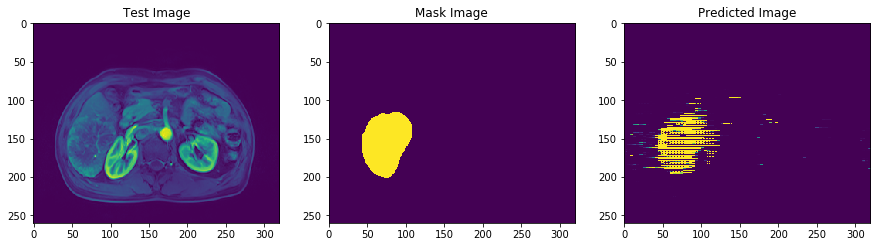

In [48]:
compare_images(fcn_predict,20)

### Predicted Image by SegNet

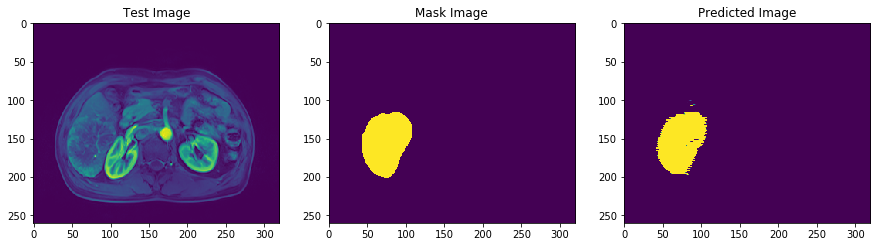

In [49]:
compare_images(segnet_predict,20)

### Predicted Image by U-Net

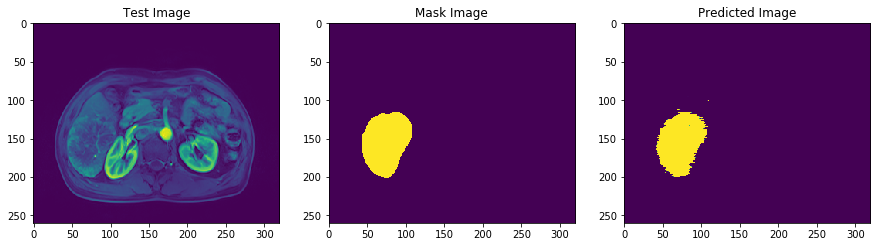

In [50]:
compare_images(unet_predict,20)